In [27]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count, desc, rank
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("Bybit_Product_Analysis").getOrCreate()
# file data way
items_path = "/content/ecommerce_data/olist_order_items_dataset.csv"
products_path = "/content/ecommerce_data/olist_products_dataset.csv"

items = spark.read.csv(items_path, header=True, inferSchema=True)
products = spark.read.csv(products_path, header=True, inferSchema=True)

# Data Modeling (Join)
df_combined = items.join(products, "product_id")
# 2. International Business Report Query
# This query addresses the "Window Functions" requirement explicitly
windowSpec = Window.partitionBy("product_category_name").orderBy(desc("price"))

df_final = df_combined.withColumn("category_rank", rank().over(windowSpec)) \
                      .filter(col("category_rank") <= 5)

df_final.createOrReplaceTempView("product_rankings")
print("Analysis Ready! Here are the most valuable products by category:")
# finally
spark.sql("""
  SELECT
        product_category_name AS category,
        product_id AS product_id,
        price AS unit_price,
        category_rank AS rank_within_category
  FROM product_rankings
  ORDER BY category ASC, rank_within_category ASC
  LIMIT 20
""").show()

Analysis Ready! Here are the most valuable products by category:
+--------------------+--------------------+------+-------------------+
|            Kategori|             Urun_ID| Fiyat|Kategori_Siralamasi|
+--------------------+--------------------+------+-------------------+
|                NULL|4c50dcc50f1512f46...|3980.0|                  1|
|                NULL|0e030462875259ec0...|2740.0|                  2|
|                NULL|eed5cbd74fac3bd79...|1989.0|                  3|
|                NULL|eed5cbd74fac3bd79...|1989.0|                  3|
|                NULL|eed5cbd74fac3bd79...|1989.0|                  3|
|                NULL|eed5cbd74fac3bd79...|1989.0|                  3|
|                NULL|eed5cbd74fac3bd79...|1989.0|                  3|
|agro_industria_e_...|2b69866f22de8dad6...|2990.0|                  1|
|agro_industria_e_...|b7a60a397d4efd05c...|2399.0|                  2|
|agro_industria_e_...|cd2f5c10e4e8dbc70...|2199.0|                  3|
|agro_indust

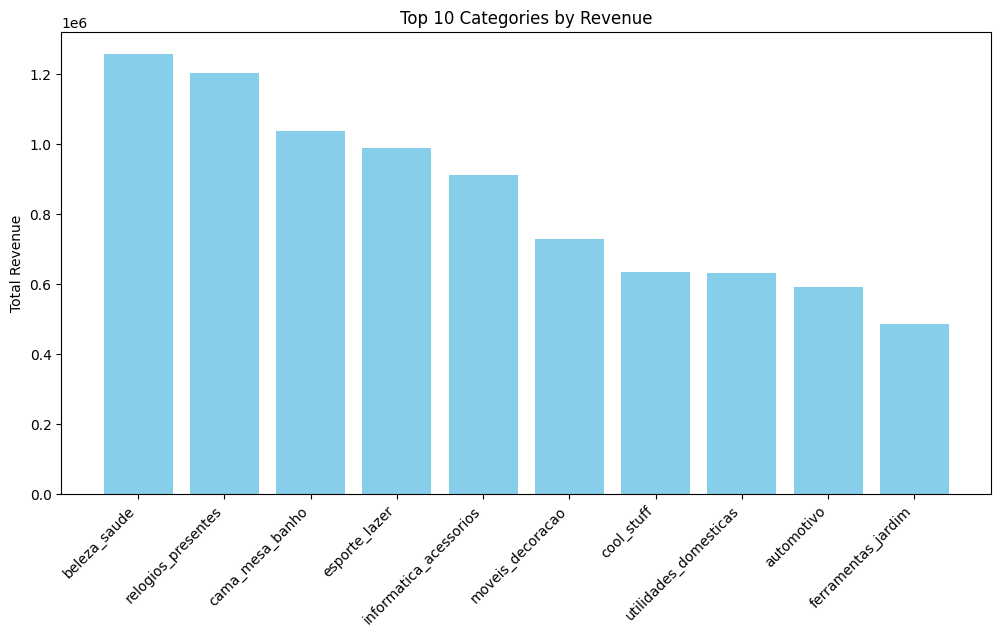

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

top_categories = df_combined.groupBy("product_category_name") \
      .agg(sum("price").alias("total_revenue")) \
      .orderBy(desc("total_revenue")) .limit(10).toPandas()

plt.figure(figsize=(12,6))
plt.bar(top_categories['product_category_name'], top_categories['total_revenue'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Categories by Revenue')
plt.ylabel('Total Revenue')
plt.show()